The task is to predict concrete strength based on sound responce from it. Input data is audio files and targets are float concrete strengths.

In [ ]:
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_io as tfio

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/audio/data'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
FILE_FORMAT = '{}.wav'

The data are presented as wav files. Let's look on them closer.

In [ ]:
audio = tfio.audio.AudioIOTensor(os.path.join(TRAIN_PATH, '021.wav'))
print(audio)

<AudioIOTensor: shape=[98299     1], dtype=<dtype: 'int16'>, rate=44100>


In [ ]:
SAMPLE_RATE = audio.rate.numpy()

In [ ]:
audio = tf.squeeze(audio.to_tensor(), axis=[-1])
print(audio)

tf.Tensor([ 0  0  0 ... 35 36 35], shape=(98299,), dtype=int16)


In [ ]:
from IPython.display import Audio

Audio(audio.numpy(), rate=SAMPLE_RATE)

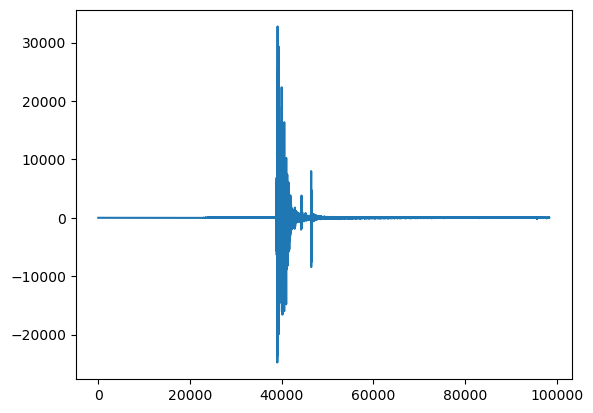

In [ ]:
plt.plot(audio.numpy());

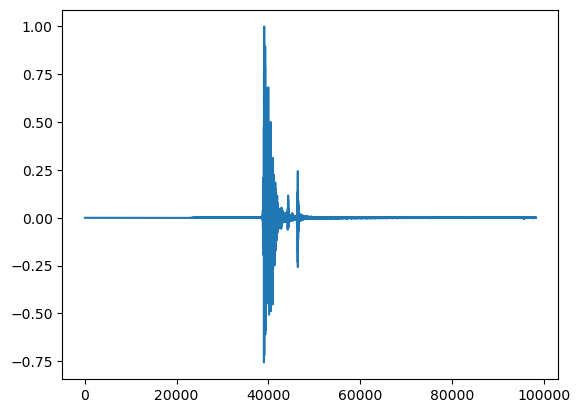

In [ ]:
tensor = tf.cast(audio, tf.float32) / 32768.0
plt.plot(tensor.numpy());

The whole file about two seconds but only a small part contains useful information. Crop the file to discard noise.

tf.Tensor([38874 46467], shape=(2,), dtype=int64)
tf.Tensor(38874, shape=(), dtype=int64) tf.Tensor(46467, shape=(), dtype=int64)


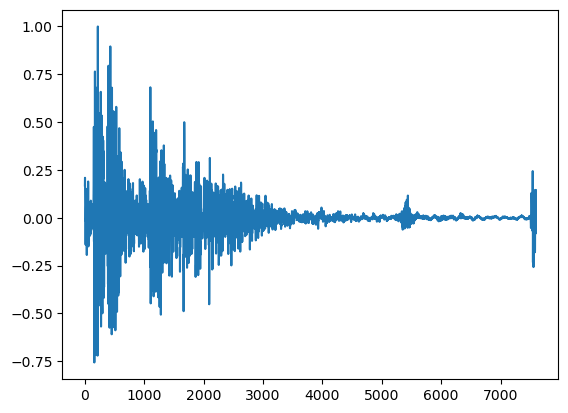

In [ ]:
position = tfio.audio.trim(tensor, axis=0, epsilon=0.1)
print(position)

start = position[0]
stop = position[1]
print(start, stop)

processed = tensor[start:stop]

plt.plot(processed.numpy());

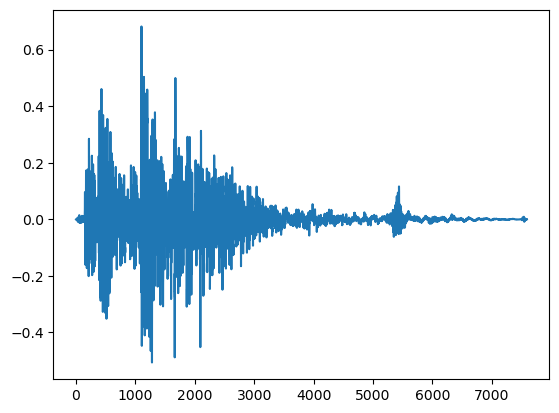

In [ ]:
fade = tfio.audio.fade(
    processed, fade_in=1000, fade_out=2000, mode="logarithmic")
plt.plot(fade.numpy());

 Audio processing often works on frequency changes over time or spectrograms.

In [ ]:
def get_spectrogram(waveform, frame_length=255, frame_step=128):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=frame_length, frame_step=frame_step)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
audio_sample = fade.numpy()[np.newaxis, :]

In [ ]:
spectrogram = get_spectrogram(audio_sample[0])

In [ ]:
def plot_spectrogram(spectrogram):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  plt.pcolormesh(X, Y, log_spec);

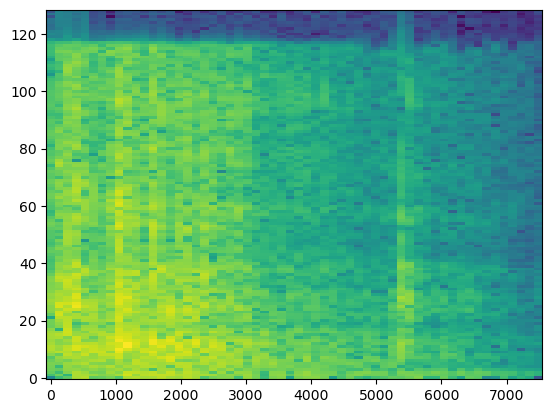

In [ ]:
plot_spectrogram(spectrogram)

# Data preparation

In [ ]:
BATCH_SIZE = 8  # Training Batch size
AUTOTUNE = tf.data.experimental.AUTOTUNE
MAX_DURATION = 4000

In [ ]:
def get_dataset(df, filepath_column, label_column):
    """
    Transforms Pandas Dataframe into Tensorflow Dataset.

    Parameters
    ----------
    df : Dataframe
        Pandas Dataframe with data.
    filepath_column: str
        Column name with paths to data files.
    label_column: str
        Column name with target values.

    Returns
    -------
    tensorflow.data.Dataset
    """
    file_path_ds = tf.data.Dataset.from_tensor_slices(
        df[filepath_column].astype(bytes))
    label_ds = tf.data.Dataset.from_tensor_slices(df[label_column])
    return tf.data.Dataset.zip((file_path_ds, label_ds))

In [ ]:
def load_audio(file_path, label, trim=True, fade=True, spectrogram=True):
    """
    Loads data from files and transforms it.

    Parameters
    ----------
    file_path: str
        Path to data file.
    label: float
        Target value for loaded data sample.
    trim: bool
        Whether the noise data should be trimmed.
        The output can't be longer then `MAX_DURATION`. True by defaul.
    fade: bool
        Whether should be applyed gradual increase and decrease on ends.
        True by defaul.
    spectrogram: bool
        Whether the data should be transformed into spectrogram. True by defaul.
    """
    audio = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
    if trim:
        position = tfio.audio.trim(audio, axis=0, epsilon=0.1)
        end = position[0][0] + MAX_DURATION
        audio = audio[position[0][0]:end]
    if fade:
        audio = tfio.audio.fade(
            audio,
            fade_in=1000,
            fade_out=2000,
            mode="logarithmic"
        )
    if spectrogram:
        audio = get_spectrogram(tf.squeeze(audio))
    return audio, label

In [ ]:
def prepare_for_training(ds, shuffle_buffer_size=512, batch_size=64):
    """
    Loads and transforms data in the dataset.

    Uses `load_audio` for loading and transformation.
    """
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.map(load_audio, num_parallel_calls=AUTOTUNE)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

Load csv file with audio files and concrete strengths.

In [ ]:
data = pd.read_csv(
    os.path.join(DATA_PATH, 'data.csv'),
    sep=';',
    names=('file_path', 'strength'),
)

In [ ]:
data.head()

,file_path,strength
0,1,81.9
1,3,53.5
2,5,45.2
3,7,75.0
4,9,64.2


`file_path` column has only file name but to load data we need path to data file.

In [ ]:
def file_name(number):
    """Transforms file name into file path."""
    number_str = str(number)
    full_number = '0' * (3 - len(number_str)) + number_str
    return os.path.join(TRAIN_PATH, FILE_FORMAT.format(full_number))

In [ ]:
data['file_path'] = data['file_path'].transform(file_name)
data.head()

,file_path,strength
0,/content/drive/MyDrive/Colab Notebooks/audio/d...,81.9
1,/content/drive/MyDrive/Colab Notebooks/audio/d...,53.5
2,/content/drive/MyDrive/Colab Notebooks/audio/d...,45.2
3,/content/drive/MyDrive/Colab Notebooks/audio/d...,75.0
4,/content/drive/MyDrive/Colab Notebooks/audio/d...,64.2


In [ ]:
data.loc[0, 'file_path']

'data\\train\\001.wav'

In [ ]:
audio, _ = load_audio(data.loc[0, 'file_path'], 1, spectrogram=False)
audio

<tf.Tensor: shape=(4000, 1), dtype=float32, numpy=
array([[0.00000000e+00],
       [1.23867430e-04],
       [9.10490126e-05],
       ...,
       [1.62455835e-05],
       [1.09425355e-05],
       [0.00000000e+00]], dtype=float32)>

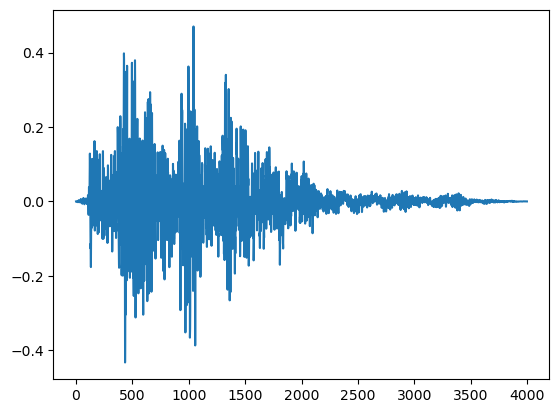

In [ ]:
plt.plot(audio.numpy());

In [ ]:
scaler = StandardScaler()
data['strength'] = scaler.fit_transform(data.values[:, 1:])
data.head()

,file_path,strength
0,/content/drive/MyDrive/Colab Notebooks/audio/d...,1.165358
1,/content/drive/MyDrive/Colab Notebooks/audio/d...,0.004364
2,/content/drive/MyDrive/Colab Notebooks/audio/d...,-0.334941
3,/content/drive/MyDrive/Colab Notebooks/audio/d...,0.883286
4,/content/drive/MyDrive/Colab Notebooks/audio/d...,0.441781


In [ ]:
train, val = train_test_split(data, test_size=0.3)
val, test = train_test_split(val, test_size=0.5)

In [ ]:
train_ds = get_dataset(data, 'file_path', 'strength')
val_ds = get_dataset(val, 'file_path', 'strength')
test_ds = get_dataset(test, 'file_path', 'strength')

In [ ]:
train_spectrogram_ds = prepare_for_training(train_ds, batch_size=BATCH_SIZE)
valid_spectrogram_ds = prepare_for_training(val_ds, batch_size=BATCH_SIZE)
test_spectrogram_ds = prepare_for_training(test_ds, batch_size=BATCH_SIZE)

# Model

In [ ]:
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense,
                                     Dropout, Input, MaxPooling2D, Flatten)
from tensorflow.keras.models import Model

In [ ]:
def ConvModel(input_shape):
    x = Input(shape=input_shape, name='input', dtype='float32')

    y = Conv2D(3, (3,3), padding='same')(x)

    y = Conv2D(32, 3, activation='relu', padding='same')(y)
    y = Conv2D(64, 3, activation='relu', padding='same')(y)
    y = MaxPooling2D()(y)
    y = Dropout(0.25)(y)
    y = Flatten()(y)

    y = Dense(128, activation='relu')(y)
    y = Dropout(0.1)(y)
    y = Dense(128, activation='relu')(y)
    y = Dropout(0.1)(y)

    out_data = Dense(1)(y)

    return Model(inputs=x, outputs=out_data)

In [ ]:
model = ConvModel(
    (30, 129, 1)
)

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30, 129, 1)]      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 30, 129, 3)        30        
                                                                 
 conv2d_14 (Conv2D)          (None, 30, 129, 32)       896       
                                                                 
 conv2d_15 (Conv2D)          (None, 30, 129, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 64, 64)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 15, 64, 64)        0         
                                                           

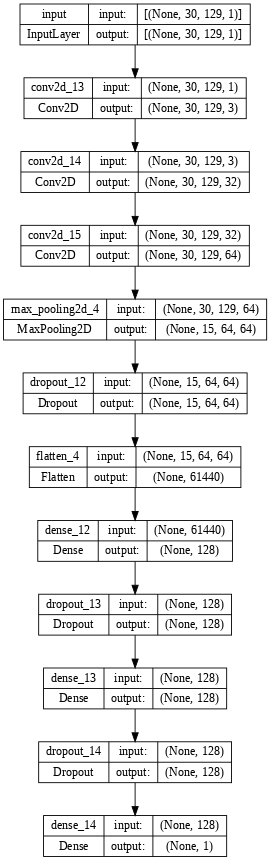

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
steps_per_epoch = len(train)//BATCH_SIZE
val_steps_per_epoch = len(val)//BATCH_SIZE

In [ ]:
history = model.fit(train_spectrogram_ds,
                    epochs=30,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_spectrogram_ds,
                    validation_steps=val_steps_per_epoch,
)

Epoch 1/30
15/15 [==============================] - 19s 1s/step - loss: 6.3189 - val_loss: 1.2099
Epoch 2/30
15/15 [==============================] - 6s 435ms/step - loss: 1.0789 - val_loss: 1.1812
Epoch 3/30
15/15 [==============================] - 6s 419ms/step - loss: 1.0442 - val_loss: 1.0135
Epoch 4/30
15/15 [==============================] - 5s 328ms/step - loss: 0.9175 - val_loss: 1.0289
Epoch 5/30
15/15 [==============================] - 5s 317ms/step - loss: 1.0220 - val_loss: 0.8812
Epoch 6/30
15/15 [==============================] - 6s 402ms/step - loss: 0.7177 - val_loss: 0.6299
Epoch 7/30
15/15 [==============================] - 5s 309ms/step - loss: 0.6525 - val_loss: 0.5524
Epoch 8/30
15/15 [==============================] - 5s 323ms/step - loss: 0.4276 - val_loss: 0.4176
Epoch 9/30
15/15 [==============================] - 6s 386ms/step - loss: 0.5117 - val_loss: 0.3182
Epoch 10/30
15/15 [==============================] - 5s 309ms/step - loss: 0.3392 - val_loss: 0.1838
E

In [ ]:
def plot_loss(hist):
    """
    Plots model loss with epoch.
    """
    loss = hist['loss']
    val_loss = hist['val_loss']
    plt.plot(loss, "--", linewidth=3, label="train")
    plt.plot(val_loss, linewidth=3, label="val")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

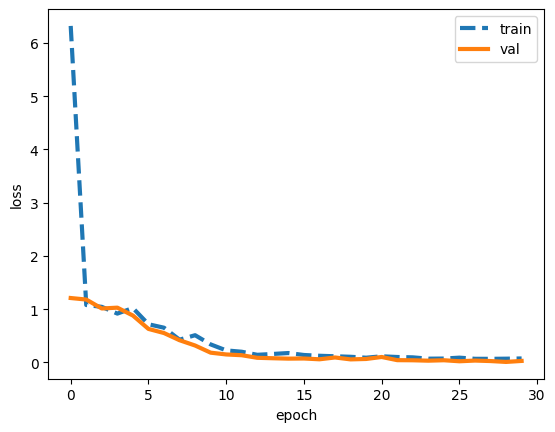

In [ ]:
plot_loss(history.history)

# Test

In [ ]:
test_steps_per_epoch = len(test)//BATCH_SIZE
predicted = model.predict(test_spectrogram_ds)

2/2 [==============================] - 0s 103ms/step


In [ ]:
predicted_df = test.copy()
predicted_df['predicted'] = scaler.inverse_transform(predicted).squeeze()
predicted_df['true'] = scaler.inverse_transform(predicted_df['strength'].values[:, np.newaxis]).squeeze()
predicted_df['difference'] = np.abs(predicted_df['true'] - predicted_df['predicted'])
predicted_df['rate'] = predicted_df['difference']/predicted_df['true']
predicted_df.head()

,file_path,strength,predicted,true,difference,rate
19,/content/drive/MyDrive/Colab Notebooks/audio/d...,0.609389,66.986580,68.3,1.313420,0.019230
42,/content/drive/MyDrive/Colab Notebooks/audio/d...,1.038630,75.368576,78.8,3.431424,0.043546
153,/content/drive/MyDrive/Colab Notebooks/audio/d...,-2.031466,7.046324,3.7,3.346324,0.904412
78,/content/drive/MyDrive/Colab Notebooks/audio/d...,0.245556,58.872360,59.4,0.527640,0.008883
145,/content/drive/MyDrive/Colab Notebooks/audio/d...,-0.502550,39.931290,41.1,1.168710,0.028436


In [ ]:
predicted_df.sort_values('rate', inplace=True)
predicted_df

,file_path,strength,predicted,true,difference,rate
41,/content/drive/MyDrive/Colab Notebooks/audio/d...,0.355932,61.914749,62.10,0.185251,0.002983
65,/content/drive/MyDrive/Colab Notebooks/audio/d...,-0.551606,40.041691,39.90,0.141691,0.003551
69,/content/drive/MyDrive/Colab Notebooks/audio/d...,-0.375821,43.993690,44.20,0.206310,0.004668
143,/content/drive/MyDrive/Colab Notebooks/audio/d...,-0.355381,44.419060,44.70,0.280940,0.006285
66,/content/drive/MyDrive/Colab Notebooks/audio/d...,-0.424878,42.661652,43.00,0.338348,0.007869
78,/content/drive/MyDrive/Colab Notebooks/audio/d...,0.245556,58.872360,59.40,0.527640,0.008883
2,/content/drive/MyDrive/Colab Notebooks/audio/d...,-0.334941,45.683270,45.20,0.483270,0.010692
18,/content/drive/MyDrive/Colab Notebooks/audio/d...,0.666621,68.938904,69.70,0.761096,0.010920
176,/content/drive/MyDrive/Colab Notebooks/audio/d...,0.691149,69.524055,70.30,0.775945,0.011038
142,/content/drive/MyDrive/Colab Notebooks/audio/d...,0.188324,57.223038,58.00,0.776962,0.013396


In [ ]:
predicted_df.to_csv('/content/drive/MyDrive/Colab Notebooks/audio/predicted.csv')